# Evaluate Confidence

In this notebook we will build the Look Up Table (LUT) for confidence score in cache.

- Requires that the prediction result (`eval_<model>_opengpt_<dataset>.pt`) already exists in the cache. If not, execute `evaluate_experiment` and `evaluate_baseline` before executing this notebook.

In [1]:
import torch
import json
import matplotlib.pyplot as plt

from itertools import product
from pathlib import Path

from tqdm.notebook import tqdm
from memoizer import load_cache

In [2]:
PATH_ROOT = Path(Path.cwd().parent.parent.parent)

PATH_CACHE = Path(PATH_ROOT, "result", "cache")
PATH_FIGURE = Path(PATH_ROOT, "result", "figures", "confidence")
PATH_PREDs = [
    Path(PATH_CACHE, "eval_t5_opengpt_final.pt"),
    Path(PATH_CACHE, "eval_t5_opengpt_original.pt"),
    Path(PATH_CACHE, "eval_t5_gpt2_output.pt"),
    Path(PATH_CACHE, "eval_roberta_opengpt_final.pt"),
    Path(PATH_CACHE, "eval_roberta_opengpt_original.pt"),
    Path(PATH_CACHE, "eval_roberta_gpt2_output.pt"),
    Path(PATH_CACHE, "eval_gpt2_opengpt_final.pt"),
    Path(PATH_CACHE, "eval_gpt2_opengpt_original.pt"),
    Path(PATH_CACHE, "eval_gpt2_gpt2_output.pt"),
    Path(PATH_CACHE, "eval_zerogpt_opengpt_final.pt"),
    Path(PATH_CACHE, "eval_zerogpt_opengpt_original.pt"),
    Path(PATH_CACHE, "eval_zerogpt_gpt2_output.pt"),
    Path(PATH_CACHE, "eval_openai_opengpt_final.pt"),
    Path(PATH_CACHE, "eval_openai_opengpt_original.pt"),
    Path(PATH_CACHE, "eval_openai_gpt2_output.pt"),
]

BINSIZE = 0.05

assert all(map(Path.exists, PATH_PREDs))

In [3]:
def calculate_confidence(prediction, thresh=0.5):
    correct_cnt = [0] * (int(1 // BINSIZE) + 1)
    total_cnt = [0] *   (int(1 // BINSIZE) + 1)

    for key in prediction:
        isPositiveLabel = key.endswith("gpt")
        isPredPositive  = prediction[key][0] > thresh

        binCnt = min(int(prediction[key][0] // BINSIZE), len(total_cnt) - 1)
        total_cnt[binCnt] += 1

        if isPositiveLabel == isPredPositive: correct_cnt[binCnt] += 1  
    
    return [(correct / total if total != 0 else 0) for correct, total in zip(correct_cnt, total_cnt)], total_cnt

def dump_confidence(p: Path, confidence_table, count):
    with open(p, "w") as f:
        json.dump({"bin_size": BINSIZE, "LUT": confidence_table, "DataCount": count}, f)

def load_confidence(p: Path, expect_bin_size: float):
    with open(p, "r") as f:
        confidence = json.load(f)
    assert confidence["bin_size"] == expect_bin_size, "Bin size for LUT does not match expected bin_size"
    return confidence["LUT"], confidence["DataCount"]


In [4]:
for cache_path in PATH_PREDs:
    prediction = load_cache(cache_path)
    model, data = cache_path.name.split("_")[1], cache_path.name.split("_")[-1].split(".")[0]
    new_name = cache_path.with_name(f"confidence_{model}_{data}.json")

    confidence, count = calculate_confidence(prediction)
    dump_confidence(new_name, confidence, count)


Loading cache from evaluate_experiment.ipynb
Loading cache from evaluate_experiment.ipynb
Loading cache from evaluate_experiment.ipynb
Loading cache from evaluate_experiment.ipynb
Loading cache from evaluate_experiment.ipynb
Loading cache from evaluate_experiment.ipynb
Loading cache from evaluate_gpt2_detector.ipynb
Loading cache from evaluate_gpt2_detector.ipynb
Loading cache from evaluate_gpt2_detector.ipynb
Loading cache from ./data/utility_fns.py
Loading cache from ./data/utility_fns.py
Loading cache from ./data/utility_fns.py
Loading cache from ./data/utility_fns.py
Loading cache from ./data/utility_fns.py
Loading cache from ./data/utility_fns.py


## Plot Confidence Level

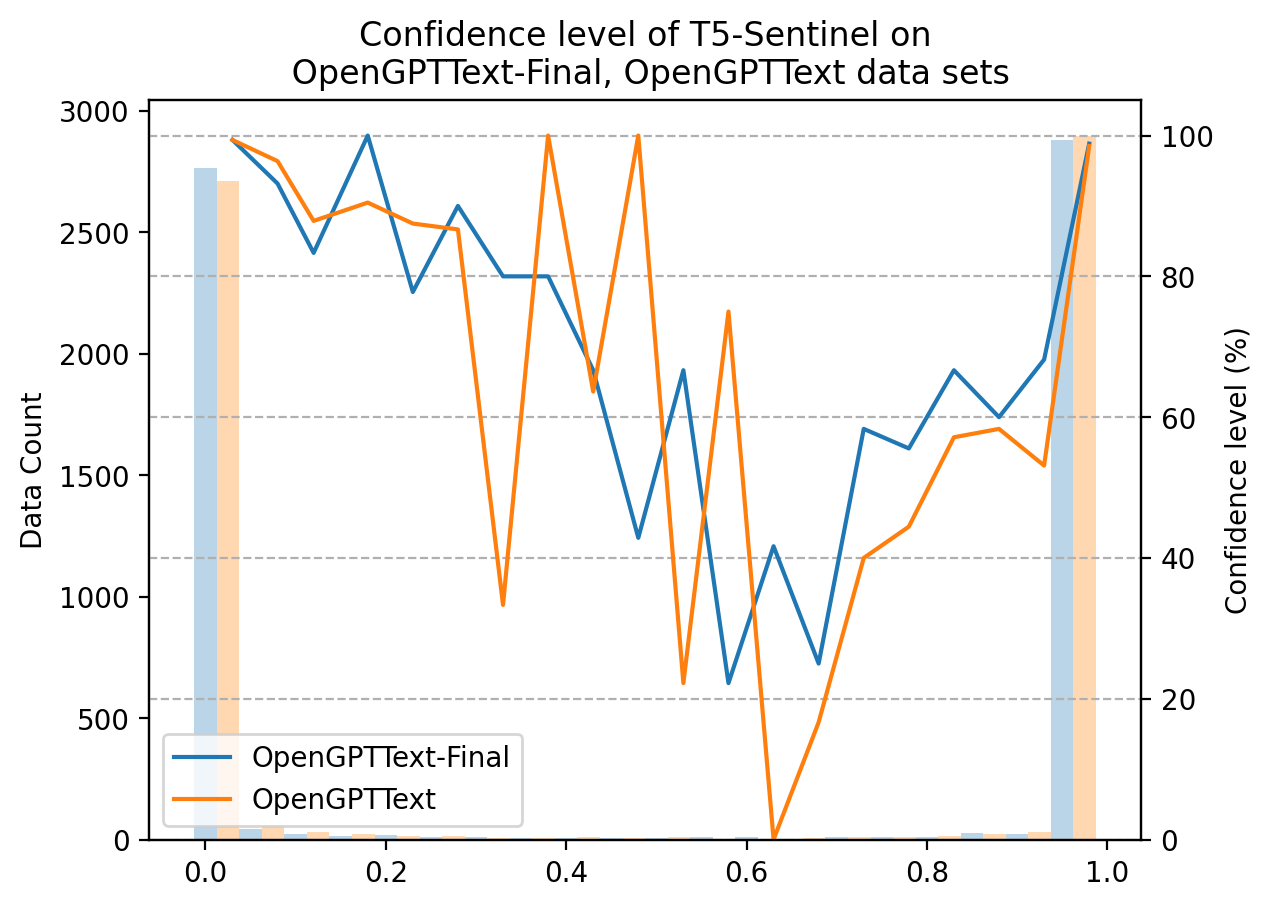

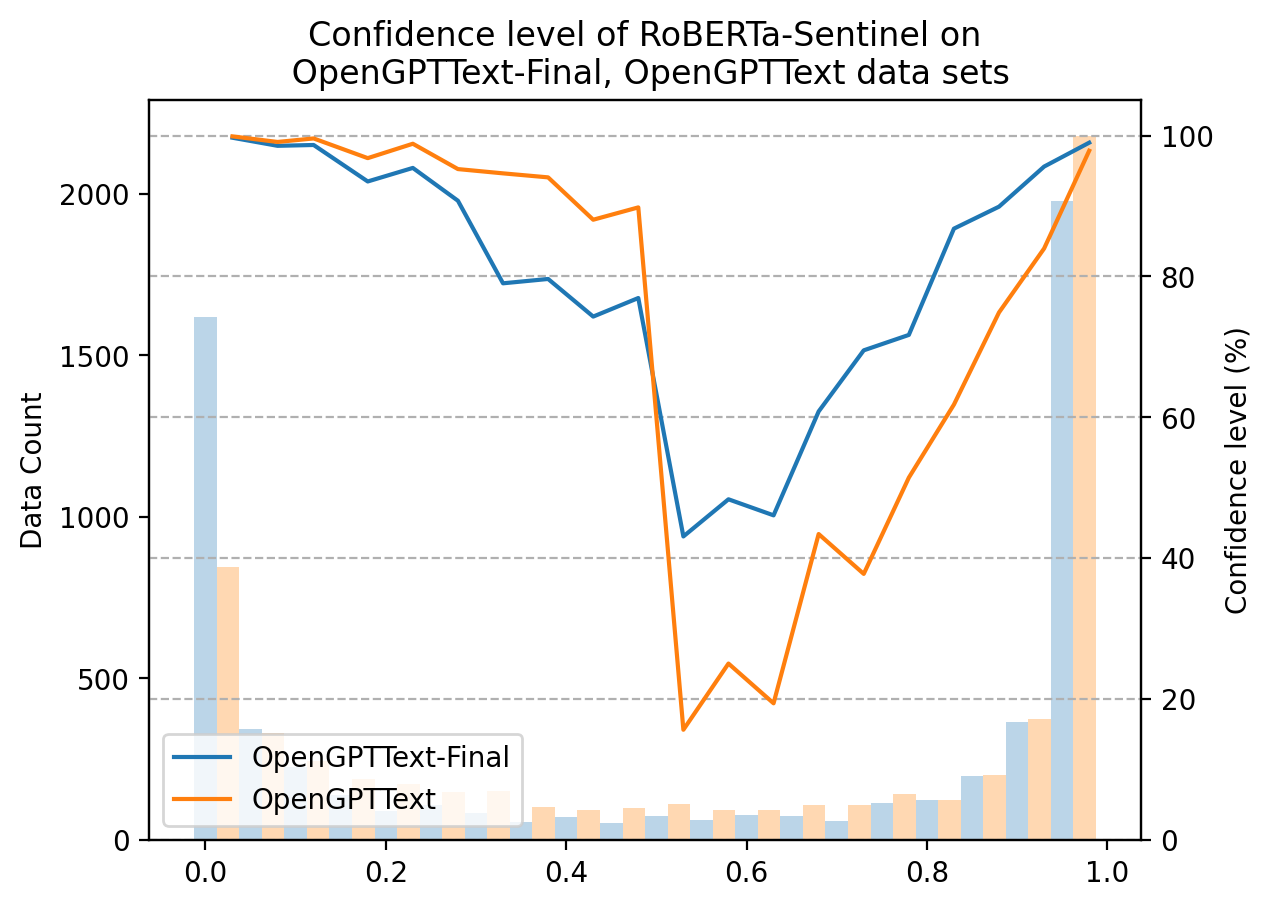

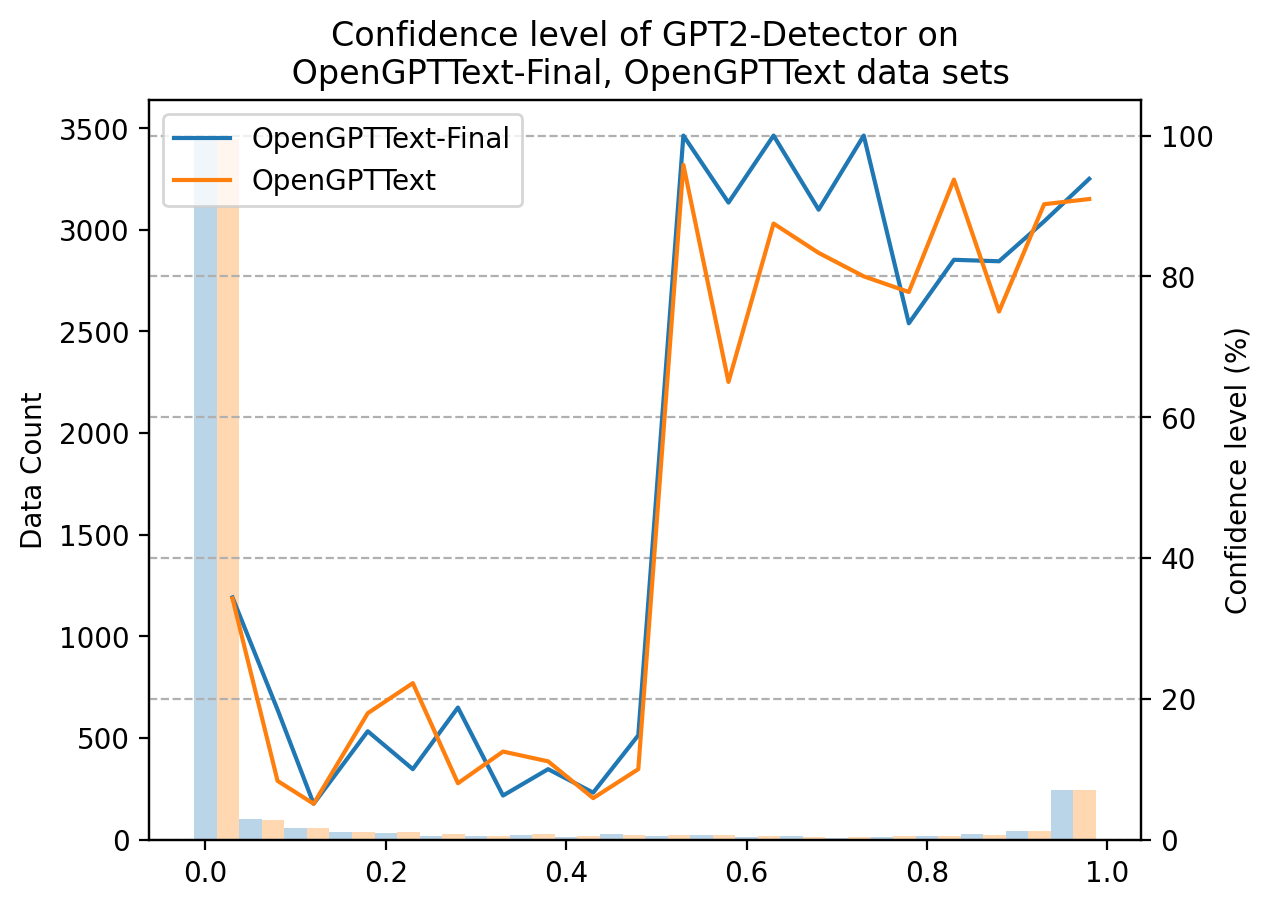

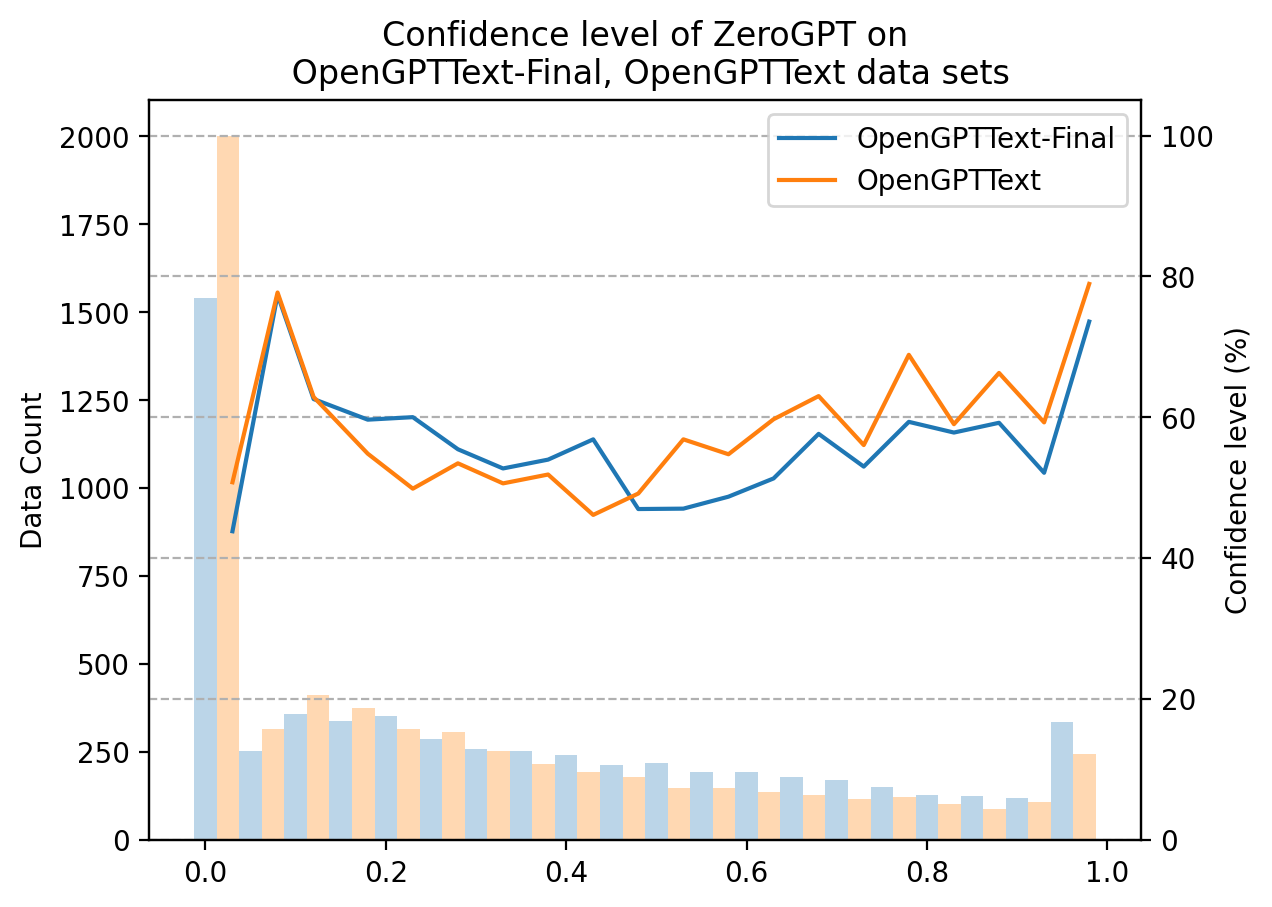

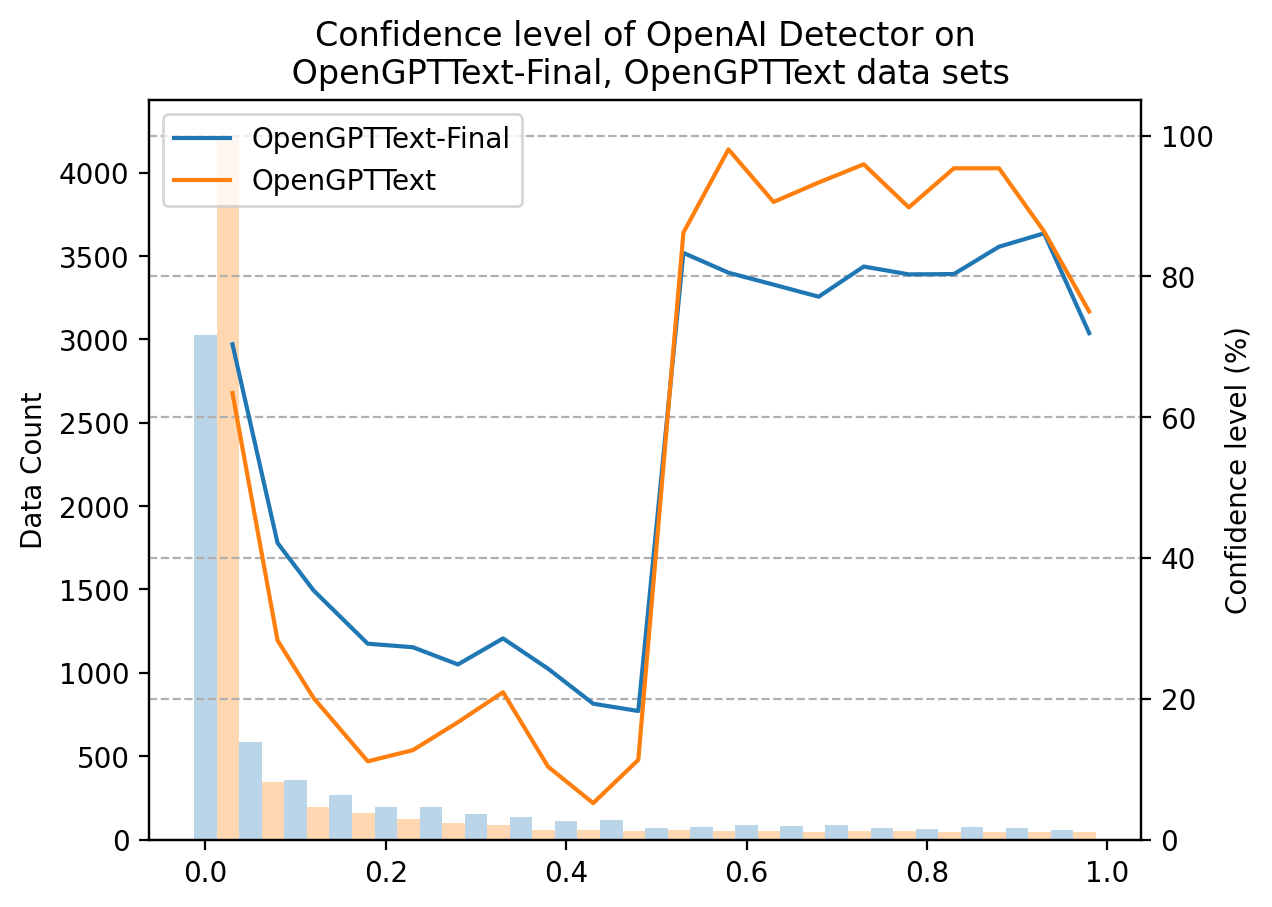

In [9]:
# S_model = ["t5", "roberta", "gpt2", "zerogpt", "openai"]
# S_data = ["final", "original", "output"]
S_model = ["t5", "roberta", "gpt2", "zerogpt", "openai"]
S_data = ["final", "original"]

display_model = lambda s: {"t5": "T5-Sentinel", "roberta": "RoBERTa-Sentinel", "gpt2": "GPT2-Detector", "zerogpt": "ZeroGPT", "openai": "OpenAI Detector"}[s]
display_data  = lambda s: {"final": "OpenGPTText-Final", "original": "OpenGPTText", "output": "GPT2-Output"}[s]
colors = [(0.12156863, 0.46666667, 0.70588235, 0.3), (1.0, 0.49803922, 0.0, 0.3), (0.17254902, 0.62745098, 0.17254902, 0.5)]

for model in S_model:
    fig, ax1 = plt.subplots(dpi=200)
    ax2 = ax1.twinx()
    ax1.set_ylabel("Data Count")
    
    for idx, data in enumerate(S_data):
        confidence_fileName = Path(PATH_CACHE, f"confidence_{model}_{data}.json")
        with open(confidence_fileName, "r") as f:
            _, count = load_confidence(confidence_fileName, expect_bin_size=BINSIZE)
        x = [_ * BINSIZE + idx * (BINSIZE / len(S_data)) for _ in range(int(1 // BINSIZE) + 1)]
        ax1.bar(x, count, color=colors[idx], width=BINSIZE / len(S_data))

    for data in S_data:
        confidence_fileName = Path(PATH_CACHE, f"confidence_{model}_{data}.json")
        with open(confidence_fileName, "r") as f:
            LUT, _ = load_confidence(confidence_fileName, expect_bin_size=BINSIZE)
        x = [round(_ * BINSIZE + 0.5 * BINSIZE, 2) for _ in range(int(1 // BINSIZE) + 1)]
        y = [prop * 100 for prop in LUT]

        ax2.plot(x, y, label=f"{display_data(data)}")

    ax2.set_title(f"Confidence level of {display_model(model)} on\n {', '.join([display_data(_) for _ in S_data])} data set{'' if len(S_data) == 1 else 's'}")
    ax2.grid(linestyle="--")
    ax2.set_xlabel("Predicted probability of generated")
    ax2.set_ylabel("Confidence level (%)")
    ax2.set_ylim(0, 105)
    ax2.legend()

    fig.savefig(Path(PATH_FIGURE, f"confidence_{model}.pdf"))
    plt.show()
